In [1]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [16]:
# This version implements a 
# spectrally variing detection threshold.
import time
import numpy as np
import spectrum
from collections import OrderedDict
import argparse
from astropy.io import fits
from astropy import wcs
import sys
from astropy.io import ascii
import os

import numpy as np
#from imageio import imread
from matplotlib import pyplot as plt
%matplotlib inline

import maxflow

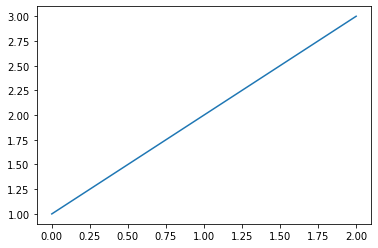

In [17]:
plt.plot([1,2,3])
plt.show()

In [4]:
def pp(s):
    print(s)
    return s + "\n"


def grow_segment(c, outmap, x, y, z, threshold, label):
    # Non object oriented version
    def get_children(zyx, shape):
        maxz, maxy, maxx = shape
        z, y, x = zyx
        children = []
        ddx = [-1,0,1]
        ddy = [-1,0,1]
        ddz = [-1,0,1]
        #ddz = [0]
        for dx in ddx:
            for dy in ddy:
                for dz in ddz:
                    if not dx == dy == dz == 0:
                        newx, newy, newz = x+dx, y+dy, z+dz
                        if newx >= 0 and newx < maxx\
                            and newy >= 0 and newy < maxy\
                            and newz >= 0 and newz < maxz:
                               children.append( (newz, newy, newx) ) 
        return children

    pixel_list = []
    stack = [(z,y,x)]
    outmap[(z,y,x)] = label

    maxiter = 1e6
    iter = 0
    while len(stack) > 0: 
        pm = stack.pop()
        pp = get_children(pm, c.shape)
        for p in pp:
            if c[p] >= threshold and  outmap[p] == 0: # pixel that are labeled 0 have not been visited yet
                stack.append(p)
                outmap[p] = label
            elif c[p] < threshold and  outmap[p] == 0:
                outmap[p] = -1 # label pixel with -1 if they have beed visited already
        iter += 1
        if iter > maxiter:
            break

    return outmap#pixel_list            


def build_map(ww, c, sigma_detect_threshold, sigma_grow_threshold, noise_model):
    # run cloud growth algorithm on all pixels above detection threshold
    # try to be intelligent, only loop over pixels that exceed detection threshold
    ii = (c.swapaxes(2,0) > np.polyval(noise_model, ww) * sigma_detect_threshold ).swapaxes(2,0)
    
    
    N =  (np.sum(ii))
    print("{} pixel above detection threshold".format(N))

    outmap = np.zeros_like(c, dtype=int)

    zz,yy,xx = [np.arange(s, dtype=int) for s in c.shape]
    YY,ZZ,XX = np.meshgrid(yy, zz, xx)

    label = 1
    for i, (x,y,z) in enumerate( zip(XX[ii], YY[ii], ZZ[ii] ) )  :  
        if outmap[z,y,x] == 0:
            pp("### {} z={} ###".format(i,z))
            print(x,y,z, outmap[z,y,x])
            #outmap = build_map2(c, outmap, x,y,z, threshold = grow_threshold, label=label)

            summary = ""
            summary += pp("Building map starting with pixel {} out of {} that exceeds threshold...".format(i,N))
            start_time = time.time()
            #print("{} labeled pixels on map".format( np.nansum( (outmap > 0).flatten())) )
            
            # Here we set to which threshold a region shoudl be grown.
            # note that this is not stricly correct, the threshold should very also inside
            # grow_segment as function of wavelength. Here we will just rely on this
            # being a slowly variing function.
            threshold = np.polyval(noise_model, ww[z]) * sigma_grow_threshold
            print("grow_threshold = ", threshold)
            outmap = grow_segment(c, outmap, x,y,z, threshold, label=label)
            time_to_build = time.time() - start_time
            summary += pp("Time to build map: {:.4e} s".format(time_to_build))

            print("{} labeled pixels on map".format( np.nansum( (outmap > 0).flatten())) )
            print("{} untouched pixels on map".format( np.nansum( (outmap == 0).flatten())) )

        label += 1

        if i > 1e6:
            break
    #print (cnt)
    return outmap


def filter_minsize(outmap, minsize):
    # filter regions with too small volume 
    rr = np.sort( np.unique( outmap.flatten() ) )
    for r in rr:
        if not r > 0:
            continue
        N = np.sum( outmap == r )
        #print("{} : N = {}".format(r, N))
        if N < minsize:
            outmap[outmap == r] = -1  
    rr = np.sort( np.unique( outmap.flatten() ) )
    
    # relabel
    for i,r in enumerate(rr[rr>0]):
        outmap[outmap == r] = i + 1

    rr = np.sort( np.unique( outmap.flatten() ) )
    print("{} regions survive size cut".format( len(rr[rr>0]) ))

    return outmap



def save_map(outmap, fmapout):
    w = wcs.WCS(s.hdu)
    # save map
    f = np.zeros_like(c)
    f[outmap > 0] = c[outmap > 0]
    wcs_header =  w.to_header()


    h = fits.PrimaryHDU(data=outmap, header=s.hdu.header)
    for k in wcs_header:
        h.header[k] = wcs_header[k]
    hdu = fits.HDUList(h)

    # save map filtered data
    f = np.zeros_like(c)
    f[outmap > 0] = c[outmap > 0]
    h = fits.ImageHDU(data=f, header=s.hdu.header, name = "filtered_data")
    for k in wcs_header:
        h.header[k] = wcs_header[k]

    hdu.append(h)

    # save shells 
    f = np.zeros_like(c)
    f[outmap == -1] = c[outmap == -1]

    h = fits.ImageHDU(data=f, header=s.hdu.header, name = "shells")
    for k in wcs_header:
        h.header[k] = wcs_header[k]
    hdu.append(h)

    hdu.writeto(fmapout, overwrite=True)
    print("Wrote {}.".format(fmapout))

 

## fast graph construction, no color or distance based weights

In [53]:
fcube = "sf2outcube_COSMOSA_022_pca.fits.gz"
fnoisemodel = "sf2outcube_COSMOSC_022_pca.detect_noise_model"
workdir = "/work/04287/mxhf/maverick/hetdex/cubes"
datadir = os.path.join(workdir, "data")

w = 12.
wz = .05

dscale = 5.


In [59]:
# read data
s = spectrum.readSpectrum(os.path.join(datadir, fcube))
ww = s.grid()

# read noise model
noise_model = np.loadtxt(os.path.join(datadir, fnoisemodel) )

# scale date by noise
c = s.data

c = dscale * np.multiply(c.T, 1./np.polyval(noise_model, ww )).T

#c = c[118-5:118+6] # for faster testing



In [60]:
# Create a graph with integer capacities.
# best guess for number of nodes and edges
nnodes = len( c.flatten() )
nedges = len( c.flatten() )*26 + 2*len( c.flatten() )
g = maxflow.Graph[float](nnodes, nedges )

nodes = g.add_grid_nodes(c.shape)

# connection weights based on Euclidian distances
structure = np.array([ w*wz* np.array([[.58, .7, .58],
                        [.7, 1, .7],
                        [.58, .7, .58]]),
                       w*np.array([[.7, 1, .7],
                        [1, 0, 1],
                        [.7, 1, .7]]),
                       w*wz*np.array([[.58, .7, .58],
                        [.7, 1, .7],
                        [.58, .7, .58]]) ])

g.add_grid_edges(nodes, structure=structure)
g.add_grid_tedges(nodes, c, 1.-c)

In [61]:
# Find the maximum flow.
g.maxflow()

# Get the segments.
sgm = g.get_grid_segments(nodes)

# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))
# Show the result.
cout = img2.reshape(c.shape)

In [62]:
#subcube = c[118-2:118+3]
#subcout = cout[118-2:118+3]
subcube = c
subcout = cout
N = subcube.shape[0]
if N < 15:
    f = plt.figure(figsize=[15,10])
    for i in range(N):
        plt.subplot(1,N,i+1)
        plt.imshow(subcube[i]/dscale, origin='bottom', interpolation='none',vmin=0., vmax=2.)

    f = plt.figure(figsize=[15,10])
    for i in range(N):
        plt.subplot(1,N,i+1)
        plt.imshow(subcout[i], origin='bottom', interpolation='none')
plt.show()

In [63]:
h = s.hdu
h.data = cout
h.writeto(os.path.join(datadir, "ct" + fcube), overwrite=True)